In [1]:

import torch
import numpy as np

from transformers import SamModel, SamProcessor
from transformers import CLIPVisionModel

import math
import os
import tiktoken

from torch.utils.data import DataLoader, Dataset

from deepencoder import CLIP_modified, conv_block, DeepEncoder
from dataloader import OCR_dataset, ocr_collate
from tqdm import tqdm

from helper import text_to_token_ids, token_ids_to_text, download_and_load_gpt2
from knowledge_transfer import load_weights_into_gpt_modified
from model import GPTModel

from pipeline import *

/Users/mohamedmafaz/Desktop/OCR Model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tokenizer = tiktoken.get_encoding('gpt2')

special_tokens = {"<image>": tokenizer.n_vocab+1}
tokenizer_modified = tiktoken.Encoding(
    name="gpt2_with_image",
    pat_str=tokenizer._pat_str,
    mergeable_ranks=tokenizer._mergeable_ranks,
    special_tokens={**tokenizer._special_tokens, **special_tokens}
)

vocab_size = tokenizer_modified.n_vocab

In [ ]:
files = os.listdir('dataset')[:20]
l = len(files)

train_frac = 0.8
test_frac  = 0.15

batch_size = 1
device = "cpu"

train_pos = int(l * train_frac)
test_pos  = int(l * test_frac)

train_files = files[: train_pos]
test_files = files[train_pos : train_pos + test_pos]
val_files  = files[train_pos + test_pos : ]

len(train_files), len(test_files), len(val_files)

(16, 3, 1)

In [59]:
train_dl = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = train_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=True,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

test_dl  = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = test_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

val_dl  =  DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = val_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

one_batch  = next(iter(train_dl))

one_batch_input_ids  = one_batch["input_ids"]
one_batch_target_ids =  one_batch["target_ids"]
one_batch_images     = one_batch["images"]

print(f"input_ids: {one_batch_input_ids.shape}")
print(f"target_ids: {one_batch_target_ids.shape}")
print(f"images: {one_batch_images.shape}")



input_ids: torch.Size([16, 8])
target_ids: torch.Size([16, 8])
images: torch.Size([16, 3, 1024, 1024])


In [6]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
deep_encoder = DeepEncoder(sam_model = sam_model, clip_model = clip_model)
deep_encoder

SAM params: 93,735,472
CLIP params: 303,179,776

In [7]:
GPT_CONFIG_124M = {
    "vocab_size"     : tokenizer.n_vocab,     # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

model_configs = {
    "gpt2-small (124M)": {"embedding_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"embedding_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"embedding_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"embedding_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-large (774M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, 
                   "qkv_bias": True, 
                   "vocab_size": tokenizer_modified.n_vocab,
                   "vision_dim": 1280})

gpt2 = GPTModel(NEW_CONFIG)
gpt2.token_embedding

Embedding(50259, 1280)

In [8]:
checkpoint = torch.load("gpt2/OCR_finetuned/gpt2_774M_finetuned.pth",
                        map_location="cpu")

gpt2.load_state_dict(checkpoint["model_state"])
gpt2.eval();

In [9]:
token_ids_to_text(one_batch_input_ids, tokenizer_modified)

'<image>\nwould have been'

In [10]:
token_ids_to_text(one_batch_target_ids, tokenizer_modified)

'\nwould have been<|endoftext|>'

In [11]:
text = generate_text(
        deep_encoder   = deep_encoder,
        gpt2           = gpt2,
        projector      = deep_encoder.projector,
        tokenizer      = tokenizer_modified,
        image          = one_batch_images,
        prompt         = "<image>\n",
        max_new_tokens = 10,
        temperature    = 0.6,
        top_k          = 100,
        device         = "cpu",
        eos_token      = 0
    )
    

Generating samples: 10: 100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


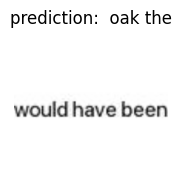

In [14]:
plt.figure(figsize=(2,2))

plt.imshow(
    one_batch_images.squeeze(0).permute(1,2,0).cpu().numpy()
)

plt.axis("off")
plt.title(f'prediction: {text.replace("<|endoftext|>", "")}')
plt.show()